# Search quantum information protocols with LOCCNet

## Table of Contents
1. [Introduction](#introduction)
2. [Quantum State Discrimination](#quantum-state-discrimination)
   - [Problem Description](#problem-description)
   - [Implementation](#implementation-with-loccnet)
3. [Quantum State Distillation](#quantum-state-distillation)
   - [Problem Setup](#problem-setup)
   - [Implementation](#implementation)
4. [References](#references)
5. [Notation Reference](#notation-reference)

In [1]:
import time
import torch
import math
import numpy as np
import matplotlib.pyplot as plt

import quairkit as qkit
from quairkit import to_state
from quairkit.application import OneWayLOCCNet
from quairkit.database import *
from quairkit.loss import *
from quairkit.operator import *
from quairkit.qinfo import *

qkit.set_dtype('complex128')

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## Introduction <a id='introduction'></a>

This tutorial explores the application of LOCCNet (Local Operations and Classical Communication Network) in quantum information protocols, particularly in the context of distributed quantum information processing. We will focus on two fundamental tasks[1]:

1. **Quantum State Discrimination**: Distinguishing between different quantum states under the restriction of LOCC, specifically discriminating between a perfect Bell state and its noisy counterpart after passing through amplitude damping channels.

2. **Quantum State Distillation**: Purifying entangled states to obtain higher-fidelity entanglement using LOCC operations.


Throughout this tutorial, we will demonstrate the practical steps for implementing these protocols. This includes setting up a OneWayLOCCNet for multiple parties, configuring the initial quantum states, and building the parameterized quantum circuits. We will also cover the implementation of parameterized LOCC operations, the visualization of the resulting circuits, and the methods for training and optimizing the network.

## Quantum State Discrimination <a id='quantum-state-discrimination'></a>

### Problem Description <a id='problem-description'></a>

As demonstrated in [1], distinguishing multipartite quantum states under the restriction of local operations and classical communication (LOCC) is both practically important and theoretically challenging. In particular, the authors focus on discriminating between a perfect Bell state and its noisy counterpart after each qubit has passed through an amplitude damping channel.

Here, to explore the power of LOCCNet in state discrimination, we consider the two ideal Bell states:

$$|\Phi^{+}\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}, \qquad |\Phi^{-}\rangle = \frac{|00\rangle - |11\rangle}{\sqrt{2}}  \tag{1}$$

and an amplitude damping channel $\mathcal{A}$ with noise parameter $\gamma$, defined by:

$$\mathcal{A}(\rho) = E_0\,\rho\,E_0^\dagger + E_1\,\rho\,E_1^\dagger       \tag{2}$$

where the Kraus operators are:

$$E_0 = |0\rangle\langle 0| + \sqrt{1-\gamma}\,|1\rangle\langle 1|, \quad E_1 = \sqrt{\gamma}\,|0\rangle\langle 1|      \tag{3}$$

Sending each qubit of $|\Phi^{-}\rangle$ through $\mathcal{A}$ yields the mixed state:

$$\Phi_1 = \mathcal{A}\otimes\mathcal{A}\bigl(|\Phi^{-}\rangle\langle\Phi^{-}|\bigr)        \tag{4}$$

while:

$$\Phi_0 = |\Phi^{+}\rangle\langle\Phi^{+}|     \tag{5}$$

remains noiseless. The goal is to distinguish between $\Phi_0$ and $\Phi_1$ via LOCC.

The ansatz used for finding QSD protocols with LOCCNet works as follows: the input state is randomly chosen from the set $\{ \Phi_0, \Phi_1 \}$ with equal probability. Alice performs a unitary gate on her qubit and measures. Then Bob performs on his qubit a unitary gate chosen based on Alice's measurement result. Bob's measurement outcome is supposed to tell which state the input state is.

### Implementation with LOCCNet <a id='implementation-with-loccnet'></a>

Now we create the OneWayLOCCNet structure. We have two spatially separated parties:
- **Alice**: Has 1 qubit, implements local operations, and performs the first measurement
- **Bob**: Has 1 qubit and performs adaptive operations based on Alice's measurement

The protocol works as follows:
1. Alice applies a parameterized unitary gate on her qubit
2. Alice measures her qubit
3. Bob receives the classical measurement result
4. Bob applies a conditional parameterized unitary based on Alice's outcome

In [2]:
def create_locc_network() -> OneWayLOCCNet:
    r"""
    Create a one-way LOCC qubit-network for quantum state discrimination.
    
    Returns:
        An initialized LOCC network
    """
    party_info = {'Alice': 1, 'Bob': 1}
    net = OneWayLOCCNet(party_info)
   
    net['Alice'].u3([0])
    net.param_locc(u3, 3, [('Alice', 0),('Bob', 0)], label='M', support_batch=False)
   
    return net

An example circuit diagram is shown below:

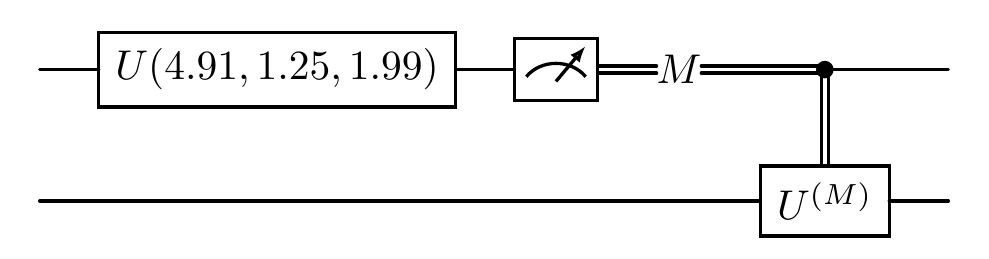

In [3]:
create_locc_network().physical_circuit.plot()

**Important Note**: In OneWayLOCC, once Alice has measured her first qubit, it cannot be measured again. This restriction ensures we maintain the one-way nature of the classical communication. The following circuit configuration would be forbidden: 

<figure style="text-align: center;">
  <img src="figures/loccnet_forbidden.png" alt="alt text"/>
  <figcaption>Forbidden Circuit. </figcaption>
</figure>

Next, we define the quantum states to be discriminated using batch processing:

In [4]:
zero2 = torch.tensor([1, 0], dtype=torch.cdouble)
one2 = torch.tensor([0, 1], dtype=torch.cdouble)
basis00 = torch.kron(zero2, zero2)
basis11 = torch.kron(one2, one2)
psi_minus = (basis00 - basis11) / math.sqrt(2)
rho_minus = psi_minus.unsqueeze(1) @ psi_minus.conj().unsqueeze(0)

def generate_single_pair(gamma: float) -> tuple[torch.Tensor, torch.Tensor]:
    r"""
    Generate a pair of quantum states: Bell state and amplitude-damped state.
    
    Args:
        gamma: Amplitude damping parameter (0 <= gamma <= 1)
    
    Returns:
        tuple: (Bell state density matrix, amplitude-damped state density matrix)
    """
    state_minus = to_state(rho_minus)
    kraus_ops = amplitude_damping_kraus(gamma)
    
    state_minus = state_minus.transform(kraus_ops, sys_idx=[0], repr_type="kraus")
    state_minus = state_minus.transform(kraus_ops, sys_idx=[1], repr_type="kraus")
    
    rho_bell = bell_state(2).density_matrix
    rho_damp = state_minus.density_matrix
    return rho_bell, rho_damp


def generate_initial_states_locc(gamma: float) -> qkit.State:
    r"""Generate batch of initial states for LOCC network training.
    
    Args:
        gamma: Amplitude damping parameter
    
    Returns:
        Batch state containing Bell and damped states
    """
    state_bell, state_damp = generate_single_pair(gamma)

    batch = torch.stack([state_bell, state_damp])
    return to_state(batch)

The loss function of this state discrimination protocol is defined as:

$$L = P(1 \mid \Phi_0) + P(0 \mid \Phi_1)       \tag{6}$$

where $P(j\mid \Phi_k)$ is the probability that Bob's final measurement yields outcome $j$ given input state $\Phi_k$. This loss function represents the total error probability in the discrimination task:
- $P(1 \mid \Phi_0)$: Probability of incorrectly identifying the Bell state $\Phi_0$ as the noisy state
- $P(0 \mid \Phi_1)$: Probability of incorrectly identifying the noisy state $\Phi_1$ as the Bell state

The implementation works as follows:
1. Set the initial shared quantum states ($\Phi_0$ and $\Phi_1$) using `net.set_init_state`. States that are not set will default to the zero state
2. Execute the LOCC protocol where Alice measures first
3. Bob performs conditional operations based on Alice's outcome
4. Measure Bob's qubit to determine the state
5. Calculate the weighted measurement results across all branches (Alice's measurement outcomes)
6. Minimize the loss function to maximize discrimination success probability

We first marginalize the measurement probabilities over all possible branches from Alice's measurement:

In [5]:
def compute_marginalized_probabilities(
    prob_tensor: torch.Tensor, probs_batch: torch.Tensor
) -> torch.Tensor:
    r"""Compute marginalized and normalized measurement probabilities.
    
    Args:
        prob_tensor: Probability tensor with shape (batch_size, ..., 2)
        probs_batch: Conditional probabilities with same shape structure
    
    Returns:
        Normalized probabilities with shape (batch_size, 2)
    """
    branch_weights = prob_tensor.sum(dim=2)
    marginalized_probs = torch.einsum('bi,bij->bj', branch_weights, probs_batch)

    norm_sum = marginalized_probs.sum(dim=1, keepdim=True)
    return marginalized_probs / norm_sum

To discriminate between the two quantum states, we classify them based on Bob's measurement outcome: an outcome of 0 corresponds to the $\Phi_0$ state (Bell state), and an outcome of 1 corresponds to the $\Phi_1$ state (damped state).

Our objective is to minimize the loss, which is defined as the average probability of misidentifying the state defined in (6).

In [6]:
def compute_discrimination_loss(normalized_probs: torch.Tensor) -> torch.Tensor:
    r"""Compute the average classification probability for state discrimination.
    
    Based on Bob's measurement outcome: 0 → Bell state, 1 → damped state.
    The function computes the average correct classification probability weighted by
    the prior distribution (0.5 each).
    
    Args:
        normalized_probs: Shape (2, 2) tensor where normalized_probs[i, j] = P(outcome j | state i)
    
    Returns:
        Weighted classification score
    """
    p0 = normalized_probs[0].real
    p1 = normalized_probs[1].real

    F0_bell = p0[0]
    T0_bell = p0[1]
    eps = 1e-10
    p0_prob = F0_bell / (F0_bell + T0_bell + eps)

    F1_damped = p1[1]
    T1_damped = p1[0]
    p1_prob = F1_damped / (F1_damped + T1_damped + eps)

    return 0.5 * p0_prob + 0.5 * p1_prob

The main loss function combines the above components:

In [7]:
meas = Measure('z')

def loss_func_locc(net: OneWayLOCCNet) -> tuple[torch.Tensor, qkit.State]:
    r"""Compute loss function for LOCC network training.

    Args:
        net: The LOCC network
        inputs: Input states (batch of Bell and damped states)

    Returns:
        tuple: (loss value, output state)
    """
    output_state = net()

    probs_batch, output_state = meas(output_state, qubits_idx=[0], keep_state=True)
    prob_tensor = output_state.probability

    normalized_probs = compute_marginalized_probabilities(prob_tensor, probs_batch)
    return compute_discrimination_loss(normalized_probs)

Now we train the network and analyze how the discrimination success probability varies with the amplitude damping parameter $\gamma$:

In [8]:
def train_locc_network(num_itr: int, lr: float, gamma: float) -> tuple[float, OneWayLOCCNet]:
    r"""
    Train the LOCC network for state discrimination.
    
    Args:
        num_itr: Number of training iterations
        lr: Learning rate
        gamma: Amplitude damping parameter
    
    Returns:
        tuple: (best loss value, trained network)
    """
    net = create_locc_network()
    inputs = generate_initial_states_locc(gamma)
    net.set_init_state([('Alice', 0), ('Bob', 0)], inputs)
    
    time_list = []
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5)
   
    best_loss = float('inf')
    best_state = None
   
    for itr in range(num_itr):
        start_time = time.time()
        optimizer.zero_grad()
        
        loss = loss_func_locc(net)
        
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        scheduler.step(loss)
        time_list.append(time.time() - start_time)
       
        if loss < best_loss:
            best_loss = loss
            best_state = {k: v.cpu().clone() for k, v in net.state_dict().items()}

        if itr % 100 == 0 or itr == num_itr - 1:
            print(f"iter: {str(itr).zfill(len(str(num_itr)))}, " +
              f"loss: {loss:.4f}, best = {best_loss:.4f}, " +
              f"lr: {scheduler.get_last_lr()[0]:.2E}, avg_time: {np.mean(time_list):.4f}s")
   
    if best_state:
        net.load_state_dict(best_state)
   
    return best_loss, net

In [9]:
NUM_ITR = 200
LR = 0.15
START_POINT = 0

gamma_vals_full = np.linspace(0.0, 1.0, 11)
gamma_vals = gamma_vals_full[START_POINT:]
results = []

print(f"Training LOCC network for gamma values: {gamma_vals}\n")

for idx, gamma in enumerate(gamma_vals):
    print(f"\nTraining gamma = {gamma:.2f} ({idx+1}/{len(gamma_vals)})")
    best_loss, trained_net = train_locc_network(NUM_ITR, LR, gamma)
    sp = 1 - best_loss
    results.append(sp)
    print(f"Result: success_prob = {sp:.6f}\n")

print("\nFinal Results:")
for gamma, sp in zip(gamma_vals, results):
    print(f"gamma = {gamma:.2f}, success_prob = {sp:.6f}")

Training LOCC network for gamma values: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Training gamma = 0.00 (1/11)
iter: 000, loss: 0.7192, best = 0.7192, lr: 1.50E-01, avg_time: 0.0256s
iter: 100, loss: 0.0000, best = 0.0000, lr: 3.75E-02, avg_time: 0.0085s
iter: 199, loss: 0.0000, best = 0.0000, lr: 9.37E-03, avg_time: 0.0100s
Result: success_prob = 1.000000


Training gamma = 0.10 (2/11)
iter: 000, loss: 0.5003, best = 0.5003, lr: 1.50E-01, avg_time: 0.0117s
iter: 100, loss: 0.0243, best = 0.0243, lr: 4.69E-03, avg_time: 0.0117s
iter: 199, loss: 0.0243, best = 0.0243, lr: 9.16E-06, avg_time: 0.0119s
Result: success_prob = 0.975654


Training gamma = 0.20 (3/11)
iter: 000, loss: 0.5029, best = 0.5029, lr: 1.50E-01, avg_time: 0.0126s
iter: 100, loss: 0.0472, best = 0.0472, lr: 9.37E-03, avg_time: 0.0105s
iter: 199, loss: 0.0472, best = 0.0472, lr: 3.66E-05, avg_time: 0.0106s
Result: success_prob = 0.952769


Training gamma = 0.30 (4/11)
iter: 000, loss: 0.6282, best = 0.6282, lr: 1.

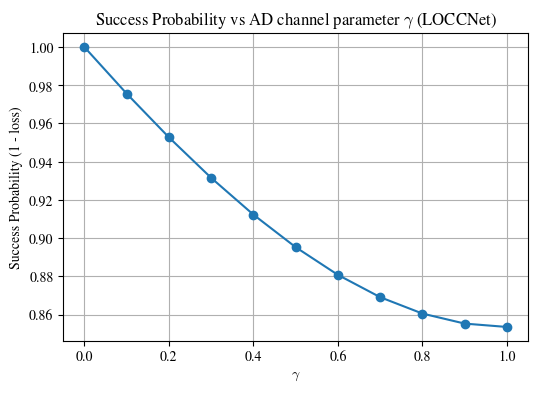

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(gamma_vals, results, marker='o')
plt.xlabel(r'$\gamma$')
plt.ylabel('Success Probability (1 - loss)')
plt.title(f'Success Probability vs AD channel parameter $\\gamma$ (LOCCNet)')
plt.grid(True)
plt.show()

As shown in the figure above, as the noise parameter $\gamma$ increases, the success probability of distinguishing between the two states $\Phi_0$ and $\Phi_1$ decreases, indicating that they become harder to distinguish.

## Quantum State Distillation <a id='quantum-state-distillation'></a>

### Problem Setup <a id='distillation-setup'></a>

Bell state distillation (also known as entanglement distillation) is a crucial task in quantum information processing. The goal is to extract high-fidelity entangled pairs from a larger number of noisy entangled pairs using only LOCC operations.

In this task, Alice and Bob share 4 noisy Bell states and they apply local operations and measurements to distill fewer but higher-quality entangled pairs, using a combination of single-qubit variational gates and CNOT gates.

### Implementation <a id='distillation-implementation'></a>

Our implementation uses OneWayLOCCNet with the following structure:
- **Alice and Bob**: Each has 4 qubits
- **Circuit architecture**: Two layers of single-qubit variational gates sandwich a layer of cycled CNOT gates
- **Optimization goal**: Maximize the fidelity of the distilled entangled pairs

In [11]:
net_purify = OneWayLOCCNet({'Alice': 4, 'Bob': 4})

net_purify['Alice'].u3([0, 1, 2, 3])
net_purify['Alice'].cnot('cycle')
net_purify['Alice'].u3([0, 1, 2, 3])

net_purify['Bob'].u3([0, 1, 2, 3])
net_purify['Bob'].cnot('cycle')
net_purify['Bob'].u3([0, 1, 2, 3])

### Purification Protocol Details

The states we want to purify are S states, which are probabilistic mixtures of Bell states and $|00\rangle$ states:

$$\rho_s = p |\Phi^+\rangle \langle \Phi^+| + (1 - p) |00\rangle \langle 00|     \tag{7}$$

The protocol works as follows:
1. Use `net.set_init_state` to set the initial state for each pair of qubits shared between Alice and Bob
2. Measure all qubits except the first qubit of Alice and Bob
3. Compare measurement results for the three qubit pairs (pairs 1, 2, and 3). We consider the distillation successful if, for each of these three pairs, Alice's measurement outcome is the same as Bob's (e.g., $m_{A_1} = m_{B_1}$, $m_{A_2} = m_{B_2}$, and $m_{A_3} = m_{B_3}$). If the measurement outcome is not in this list, the protocol fails for this round, and the pair is discarded.
4. If the measurement outcomes for any pair do not match, the protocol fails for this round, and the pair is discarded.
5. If successful, use partial trace to discard the measured states (pairs 1, 2, and 3).
6. The remaining state (on the first pair of qubits, pair 0) is the distilled state.

Our loss function is $1 - F$, where $F$ is the state fidelity between the distilled state (after partial trace) and the target EPR state $|\Phi^{+}\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$.

In [12]:
meas = Measure('zzzzzz')
target_state = bell_state(2)

measurement_qubits = [1, 5, 2, 6, 3, 7]
successful_outcomes = [
    '000000', '000011', '001100', '110000',
    '001111', '111100', '110011', '111111'
]

def purify(net: OneWayLOCCNet, share_entangle: bool) -> torch.Tensor:
    r""" Perform entanglement purification protocol.
    
    Args:
        net: The purification LOCC network
        share_entangle: Whether share entangled pairs initially
    """

    net._state_map.clear()

    if share_entangle:
        for i in range(4):
            net.set_init_state([('Alice', i), ('Bob', i)])

    status = net()
    _, post_state = meas(status, qubits_idx=measurement_qubits, 
                         desired_result=successful_outcomes, keep_state=True)
    
    reduced_state = partial_trace(post_state, measurement_qubits)
    return 1 - state_fidelity(reduced_state, target_state).mean()

Now we define the S state parameter $p = 0.7$ and begin training:

In [13]:
NUM_ITR = 100
LR = 0.2

p = 0.7

In [14]:
time_list = []
opt = torch.optim.Adam(net_purify.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.5)

for itr in range(NUM_ITR):
    start_time = time.time()
    opt.zero_grad()
    
    loss_bell = purify(net_purify, share_entangle=True)
    loss_00 = purify(net_purify, share_entangle=False)
    
    loss = p * loss_bell + (1-p) * loss_00
    
    loss.backward()
    opt.step()
    
    loss = loss.item()
    scheduler.step(loss)
    time_list.append(time.time() - start_time)
    
    if itr % 20 == 0 or itr == NUM_ITR - 1:
        print(f"iter: {str(itr).zfill(len(str(NUM_ITR)))}, " +
              f"loss: {loss:.4f}, " +
              f"lr: {scheduler.get_last_lr()[0]:.2E}, avg_time: {np.mean(time_list):.4f}s")

final_loss_bell = purify(net_purify, share_entangle=True)
final_loss_00 = purify(net_purify, share_entangle=False)
final_loss = p * final_loss_bell + (1-p) * final_loss_00

final_fidelity = 1 - final_loss.item()
print(f"\nTraining Complete! Final Fidelity: {final_fidelity:.5f}")

iter: 000, loss: 0.5949, lr: 2.00E-01, avg_time: 0.0775s
iter: 020, loss: 0.0977, lr: 2.00E-01, avg_time: 0.0547s
iter: 040, loss: 0.0893, lr: 2.00E-01, avg_time: 0.0544s
iter: 060, loss: 0.0880, lr: 2.00E-01, avg_time: 0.0536s
iter: 080, loss: 0.0879, lr: 2.00E-01, avg_time: 0.0538s
iter: 099, loss: 0.0879, lr: 2.00E-01, avg_time: 0.0533s

Training Complete! Final Fidelity: 0.91213


We first establish the baseline fidelity by calculating the fidelity between the initial S state $\rho_s$ and the target Bell state $\rho_{target} = |\Phi^+\rangle\langle\Phi^+|$.

The fidelity formula for a mixed state $\rho_s$ and a pure target state $\rho_{target}$ simplifies to:

$$F_{\text{original}} = \text{Tr}(\rho_s \cdot \rho_{target}) = \text{Tr}\left( (p |\Phi^+\rangle \langle \Phi^+| + (1 - p) |00\rangle \langle 00|) \cdot |\Phi^+\rangle \langle \Phi^+| \right)$$

This calculation yields the simplified formula:

$$F_{\text{original}} = \frac{p+1}{2}$$

For our initial state with $p=0.7$, the baseline fidelity is:

$$F_{\text{original}} = \frac{0.7 + 1}{2} = 0.85$$

Our resulting distilled fidelity of 0.9212 is higher than this 0.85 baseline, demonstrating that the LOCCNet protocol successfully purified the entanglement.

The experimental circuit diagram is shown below:

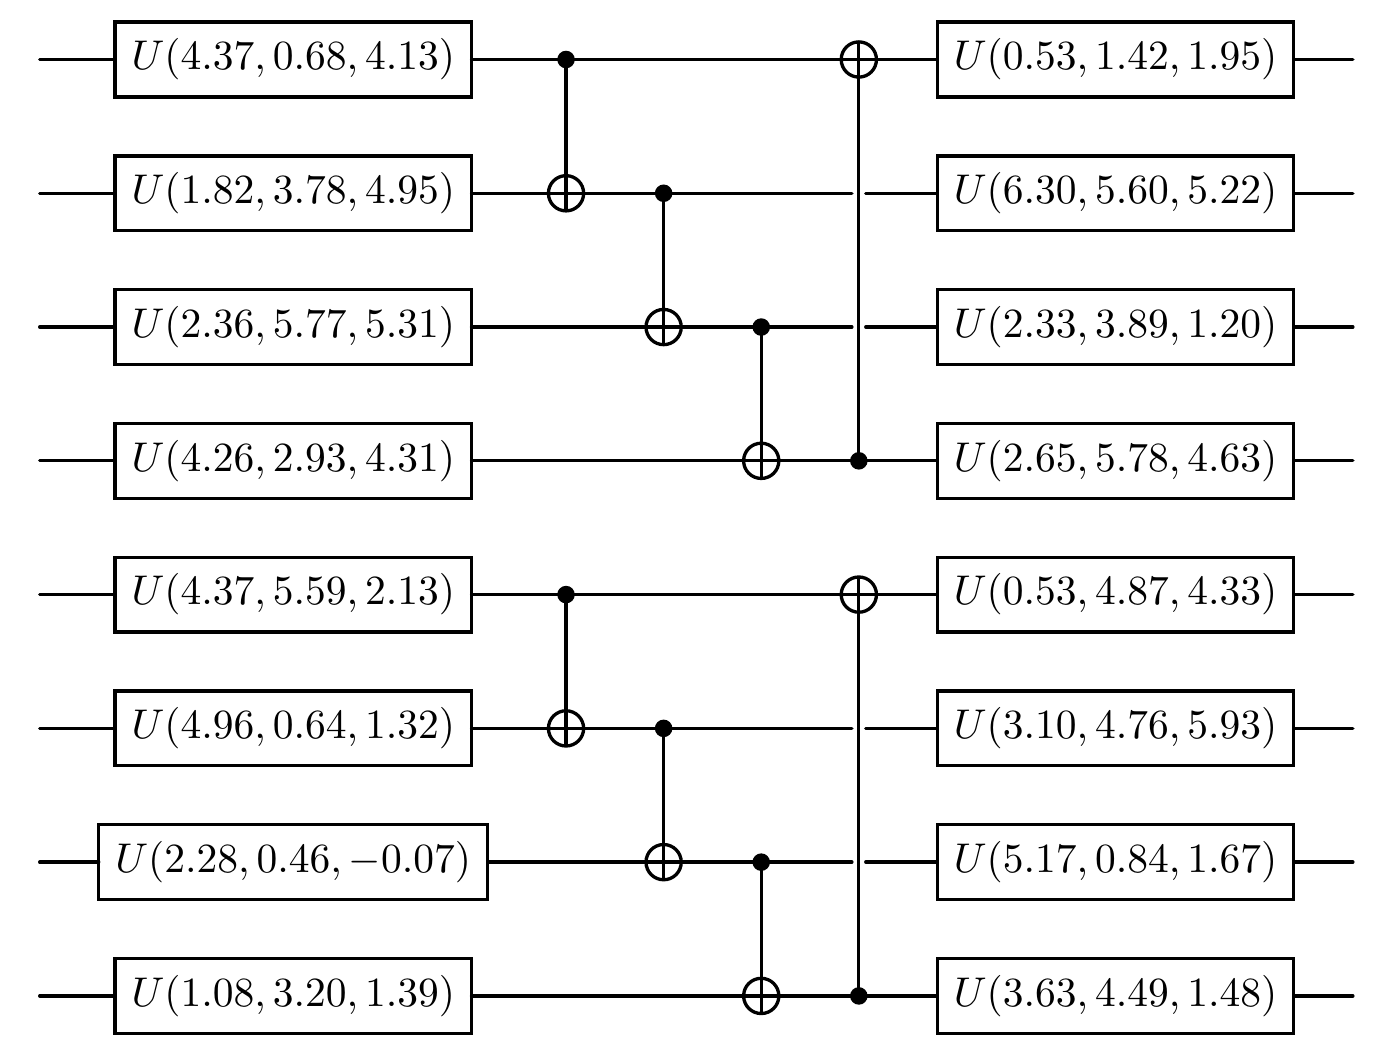

In [15]:
net_purify.physical_circuit.plot()

## References <a id='references'></a>

[1] Zhao, Xuanqiang, et al. "Practical distributed quantum information processing with LOCCNet." npj Quantum Information 7.1 (2021): 159.

## Notation Reference <a id='notation-reference'></a>

*Table: A reference of notation conventions in this tutorial.*

| Symbol | Variant | Description |
|:------:|:-------:|-------------|
| $\|\Phi^{+}\rangle$ | | Bell state (maximally entangled) |
| $\|\Phi^{-}\rangle$ | | Bell state with phase flip |
| $\|00\rangle$ |  | Product state of two qubits in zero state |
| $\mathcal{A}$ | | Amplitude damping channel |
| $\gamma$ | | Noise parameter for amplitude damping |
| $E_0, E_1$ | | Kraus operators for the amplitude damping channel |
| $\rho$ | | Density matrix |
| $\Phi_0$ | | Noiseless Bell state (to be discriminated) |
| $\Phi_1$ | | Noisy state after amplitude damping (to be discriminated) |
| $L$ | | Loss function |
| $P(j\|\Phi_k)$ | | Conditional probability of outcome $j$ given state $\Phi_k$ |
| $\rho_s$ | | S state (mixed state for purification) |
| $p$ | | Mixing parameter in S state |
| $F$ | | State fidelity |

In [16]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.4
torch: 2.8.0+cpu
numpy: 2.2.6
scipy: 1.15.3
matplotlib: 3.10.6
---------SYSTEM---------
Python version: 3.10.18
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
